Блокнот содержит готовый набор моделей для **прогнозирования временных рядов** (в данном примере - стоимость акций)

**Используемые модели:** LSTM, RNN, Arima

In [ ]:
# библиотеки для предобработки данных
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import plotly.express as px
import datetime as dt
%matplotlib inline

# **Обработка данных**


In [ ]:
# самый большой датасет по акциям Apple
data = pd.read_csv("/content/AAPL.csv" , sep=",", parse_dates=['Date'] )
data.head(4)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600


In [ ]:
data.shape

(10611, 7)

In [ ]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [ ]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data.isnull().mean()

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10611.000000,10611.000000,10611.000000,10611.000000,10611.000000,1.061100e+04
mean,16.554691,16.742895,16.367136,16.561393,15.891529,3.274810e+08
std,35.254055,35.680681,34.834442,35.272444,34.949074,3.377912e+08
min,0.049665,0.049665,0.049107,0.049107,0.038213,0.000000e+00
25%,0.287444,0.294643,0.281072,0.287388,0.237612,1.213016e+08
50%,0.486607,0.493862,0.477679,0.486607,0.403960,2.145696e+08
75%,16.220536,16.335713,16.034820,16.165357,13.978872,4.066944e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,7.421641e+09


<Axes: xlabel='Date', ylabel='Close'>

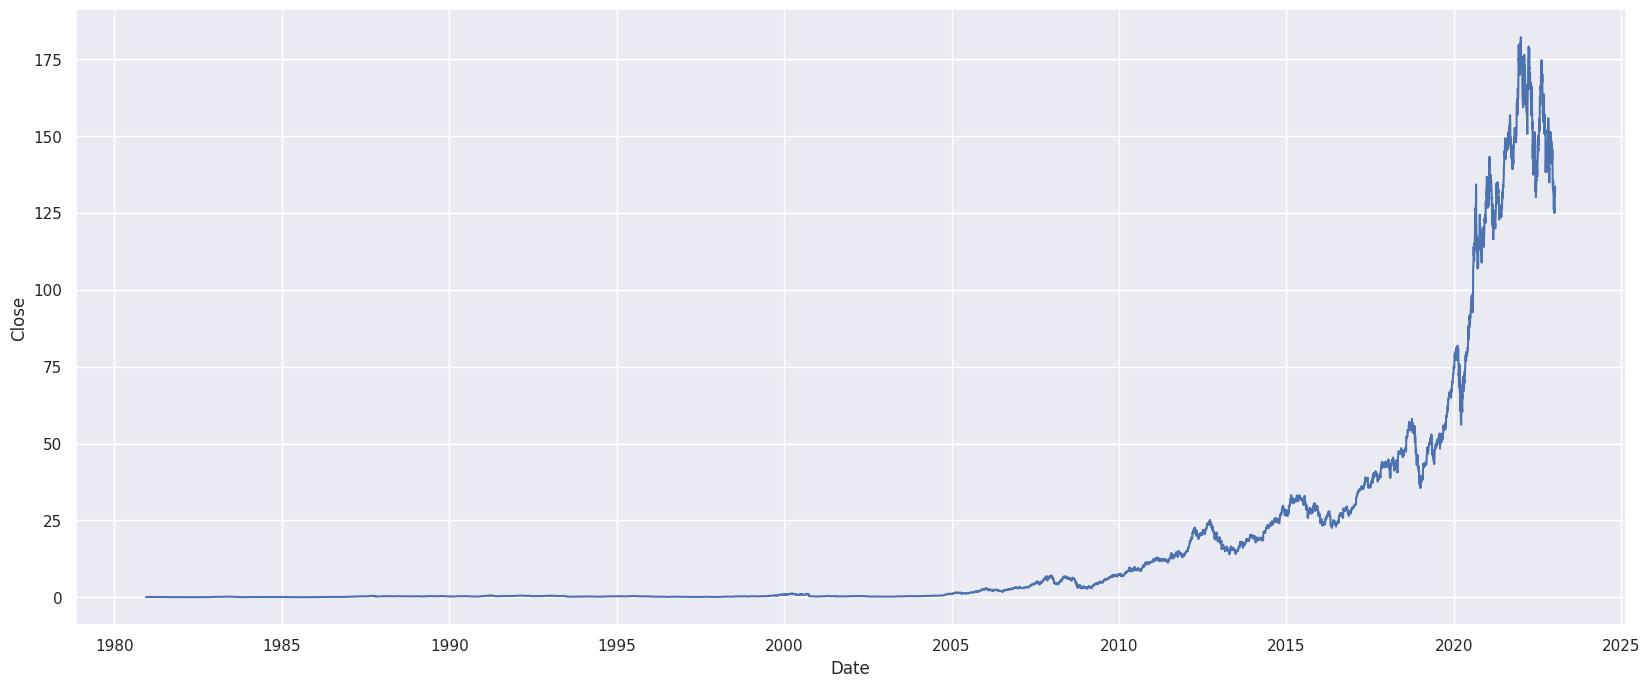

In [ ]:
# общий график всех акций
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=data, x="Date", y="Close")
# sns.lineplot(data=intel, x="Date", y="Close")
# sns.lineplot(data=jp_morgan, x="Date", y="Close")
# sns.lineplot(data=marsk, x="Date", y="Close")
# sns.lineplot(data=visa, x="Date", y="Close")

<ipython-input-11-1adf78e0d14a>:17: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace=True)


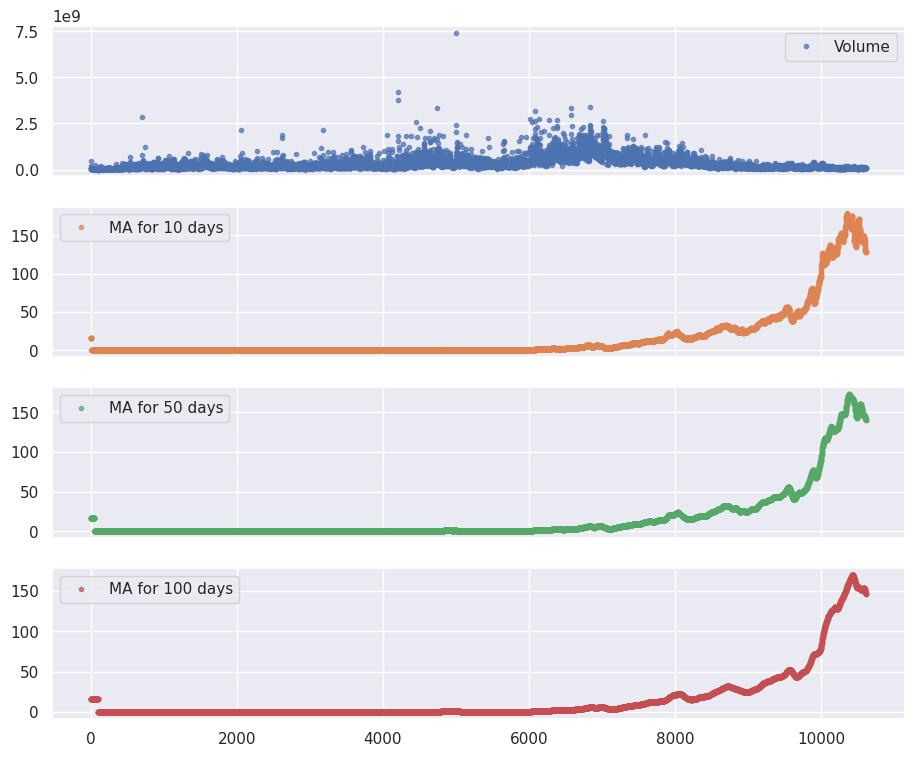

In [ ]:
# список значений для скользящего среднего
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()

date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)

# востановление индексов
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.sort_index(axis=1,ascending=True)

# визуализация данных
cols_plot = ['Volume','MA for 10 days','MA for 50 days','MA for 100 days']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)

<Axes: >

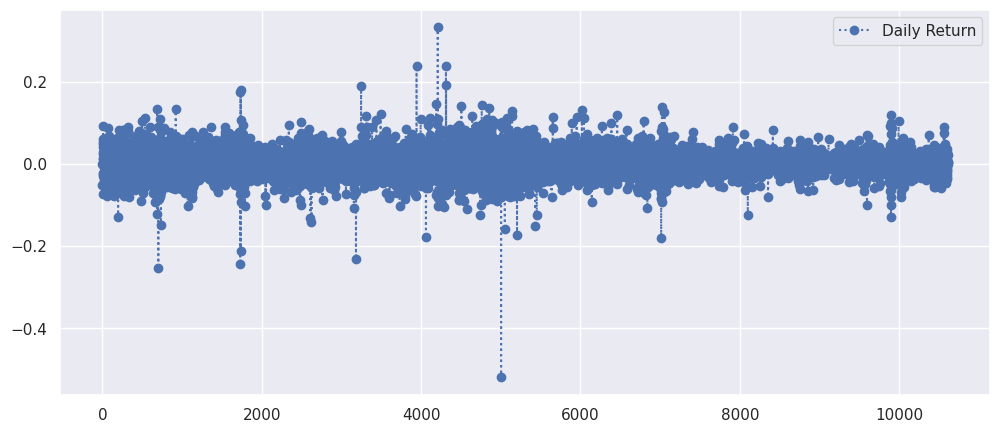

In [ ]:
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')

# **RNN модель**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# отберем необходимый промежуток времени
data = data.query("Date >= '2010-01-01'")
# разделим данные на тестовую и обучающую выборку в соотношении 80/20
training_size = int(len(data)*0.80)
data_len = len(data)
train = data[0:training_size]
test = data[training_size:data_len]
# посмотрим описательную статистику
print("Общая размерность: --> ", data_len)
print("Выборка тренировочная --> ", len(train))
print("Выборка тестовая --> ", len(test))

Общая размерность: -->  3280
Выборка тренировочная -->  2624
Выборка тестовая -->  656


In [ ]:
# преобразуем данные для модели
train = train.loc[:, ["Open"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

# попробуем реализовать rnn модель
end_len = len(train_scaled)
X_train = []
y_train = []
timesteps = 40

for i in range(timesteps, end_len):
    X_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# изменим входные данные
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train --> ", X_train.shape)
print("y_train --> ", y_train.shape)

X_train -->  (2584, 40, 1)
y_train -->  (2584,)


In [ ]:
# создание модели
regressor = Sequential()

regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [ ]:
# компилирование модели
regressor.compile(optimizer= "adam", loss = "mean_squared_error")
# количество подходов обучения
epochs = 50
# размер выборки
batch_size = 20
# обучение модели
regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
130/130 [==============================] - 25s 132ms/step - loss: 0.2182
Epoch 2/50
130/130 [==============================] - 18s 140ms/step - loss: 0.0787
Epoch 3/50
130/130 [==============================] - 18s 135ms/step - loss: 0.0369
Epoch 4/50
130/130 [==============================] - 19s 142ms/step - loss: 0.0218
Epoch 5/50
130/130 [==============================] - 19s 148ms/step - loss: 0.0153
Epoch 6/50
130/130 [==============================] - 17s 134ms/step - loss: 0.0113
Epoch 7/50
130/130 [==============================] - 18s 141ms/step - loss: 0.0093
Epoch 8/50
130/130 [==============================] - 18s 136ms/step - loss: 0.0079
Epoch 9/50
130/130 [==============================] - 18s 141ms/step - loss: 0.0058
Epoch 10/50
130/130 [==============================] - 17s 135ms/step - loss: 0.0053
Epoch 11/50
130/130 [==============================] - 18s 141ms/step - loss: 0.0042
Epoch 12/50
130/130 [==============================] - 17s 134ms/step - lo

In [ ]:
# создание прогноза на тестовых данных
real_price = test.loc[:, ["Open"]].values
print("Real Price Shape --> ", real_price.shape)

Real Price Shape -->  (656, 1)


In [ ]:
# использование анаологичной фичи как и при обучении
dataset_total = pd.concat((data["Open"], test["Open"]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(timesteps, 692):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)

print("X_test shape --> ", X_test.shape)

X_test shape -->  (652, 40)


In [ ]:
# проверка модели на тестоввых данных
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predict = regressor.predict(X_test)
predict = scaler.inverse_transform(predict)

21/21 [==============================] - 1s 15ms/step


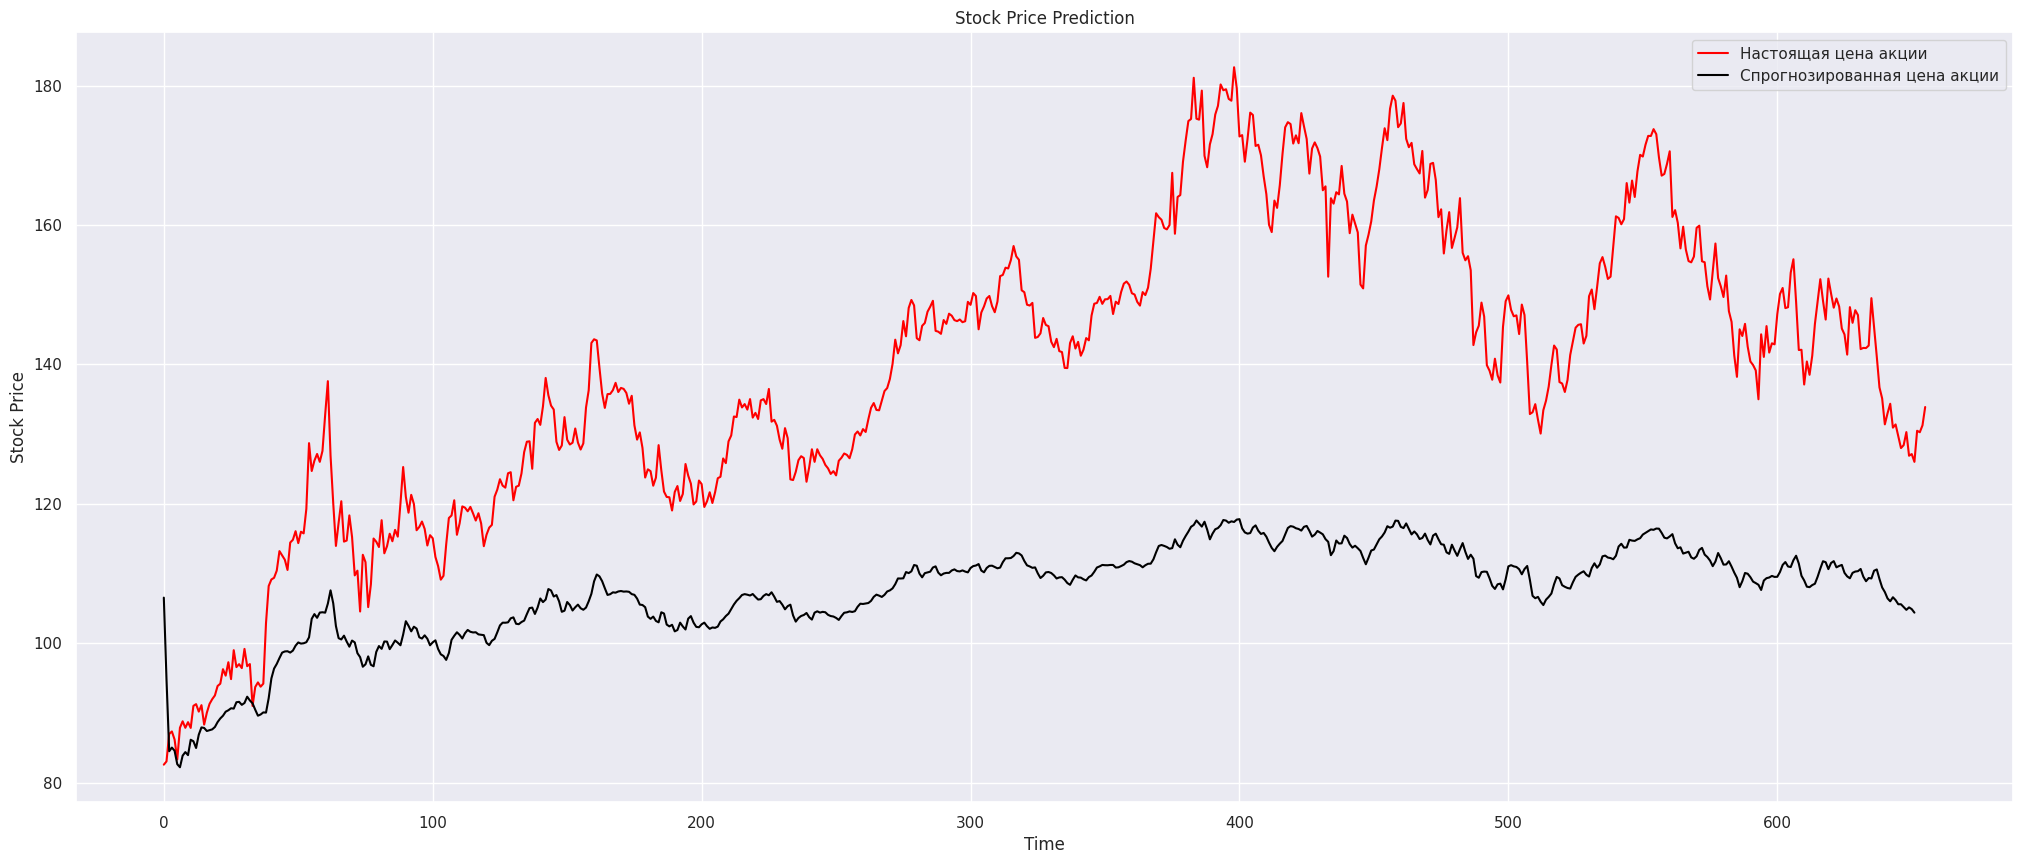

In [ ]:
# визуализация данных
plt.figure(figsize=(25, 10))
plt.plot(real_price, color = "red", label = "Настоящая цена акции")
plt.plot(predict, color = "black", label = "Спрогнозированная цена акции")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# **LSTM модель 1.5v**

In [ ]:
import matplotlib.pyplot as plt
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# отберем необходимый промежуток времени
data = data.query("Date >= '2010-01-01'")
# разделим данные на тестовую и обучающую выборку в соотношении 80/20
training_size = int(len(data)*0.80)
data_len = len(data)
train = data[0:training_size]
test = data[training_size:data_len]

In [ ]:
# нормализация данных
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['Open'].values.reshape(-1,1))

In [ ]:
# переменная прогноза и скольжения
prediction_days = 70

# инициализируйте пустые списки для ввода и вывода обучающих данных
x_train = []
y_train = []

# выполним итерацию по масштабированным данным, начиная с индекса prediction_days
for x in range(prediction_days, len(scaled_data)):
    # добавим значения в созданные списки
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

# преобразуем списки в массив
x_train, y_train = np.array(x_train), np.array(y_train)
# преобразуем в 3д массив как требует того модель
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
def LSTM_model():
    # инициализация модели
    model = Sequential()

    # добавим первый слой LSTM с 50 единицами, входной формой и возвращаемыми последовательностями
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # отсев значений чтобы убрать переобучение модели
    model.add(Dropout(0.2))

    # добавим второй слой LSTM с 50 единицами, входной формой и возвращаемыми последовательностями
    model.add(LSTM(units=50, return_sequences=True))
    # отсев значений чтобы убрать переобучение модели
    model.add(Dropout(0.2))

    # добавим третий слой LSTM с 50 единицами
    model.add(LSTM(units=50))
    # отсев значений чтобы убрать переобучение модели
    model.add(Dropout(0.2))

    # выходной слой
    model.add(Dense(units=1))

    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 70, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 70, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 70, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 70, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
# обучение модели
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
79/80 [============================>.] - ETA: 0s - loss: 0.0114

80/80 [==============================] - 7s 13ms/step - loss: 0.0113
Epoch 2/25
80/80 [==============================] - ETA: 0s - loss: 0.0023

80/80 [==============================] - 1s 11ms/step - loss: 0.0023
Epoch 3/25
79/80 [============================>.] - ETA: 0s - loss: 0.0021

80/80 [==============================] - 1s 11ms/step - loss: 0.0021
Epoch 4/25
80/80 [==============================] - ETA: 0s - loss: 0.0018

80/80 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 5/25
79/80 [============================>.] - ETA: 0s - loss: 0.0015

80/80 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 6/25
79/80 [============================>.] - ETA: 0s - loss: 0.0015

80/80 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 7/25
80/80 [==============================] - ETA: 0s - loss: 0.0015

80/80 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 8/25
80/80 [==============================] - ETA: 0s - loss: 0.0014

80/80 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 9/25
78/80 [============================>.] - ETA: 0s - loss: 0.0013

80/80 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 10/25
80/80 [==============================] - ETA: 0s - loss: 0.0014

80/80 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 11/25
78/80 [============================>.] - ETA: 0s - loss: 0.0015

80/80 [==============================] - 1s 15ms/step - loss: 0.0015
Epoch 12/25
80/80 [==============================] - ETA: 0s - loss: 0.0013

80/80 [==============================] - 1s 14ms/step - loss: 0.0013
Epoch 13/25
80/80 [==============================] - ETA: 0s - loss: 0.0013

80/80 [==============================] - 1s 11ms/step - loss: 0.0013
Epoch 14/25
79/80 [============================>.] - ETA: 0s - loss: 0.0011

80/80 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 15/25
76/80 [===========================>..] - ETA: 0s - loss: 9.8446e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.9266e-04
Epoch 16/25
79/80 [============================>.] - ETA: 0s - loss: 0.0011

80/80 [==============================] - 1s 12ms/step - loss: 0.0011
Epoch 17/25
80/80 [==============================] - ETA: 0s - loss: 9.8347e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.8347e-04
Epoch 18/25
79/80 [============================>.] - ETA: 0s - loss: 9.4359e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.4207e-04
Epoch 19/25
78/80 [============================>.] - ETA: 0s - loss: 9.7894e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.7341e-04
Epoch 20/25
80/80 [==============================] - ETA: 0s - loss: 9.5270e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.5270e-04
Epoch 21/25
80/80 [==============================] - ETA: 0s - loss: 0.0012

80/80 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 22/25
76/80 [===========================>..] - ETA: 0s - loss: 9.3951e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.3748e-04
Epoch 23/25
79/80 [============================>.] - ETA: 0s - loss: 9.2634e-04

80/80 [==============================] - 1s 14ms/step - loss: 9.3455e-04
Epoch 24/25
78/80 [============================>.] - ETA: 0s - loss: 9.0247e-04

80/80 [==============================] - 1s 15ms/step - loss: 9.0296e-04
Epoch 25/25
78/80 [============================>.] - ETA: 0s - loss: 8.6102e-04

80/80 [==============================] - 1s 12ms/step - loss: 8.6567e-04


In [ ]:
test = data[training_size:data_len]
test_data = test
# извлечение фактических цен открытия из тестовых данных
actual_prices = test_data['Open'].values

# обьединение данных
total_dataset = pd.concat((data['Open'], test_data['Open']), axis=0)

# извлечение части данных
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# преобразование данных в массив с одни столбцом
model_inputs = model_inputs.reshape(-1, 1)

# соотнесение данных обучающие и тестовые
model_inputs = scaler.transform(model_inputs)

In [ ]:
# создание пустого списка
x_test = []

# инициализируйте пустые списки для ввода и вывода обучающих данных
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# конвертация типов данных
x_test = np.array(x_test)

# подготовка данных
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# создание прогноза
predicted_prices = model.predict(x_test)

# конвертирование прогноза
predicted_prices = scaler.inverse_transform(predicted_prices)

21/21 [==============================] - 1s 7ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predicted_prices - actual_prices) ** 2)))
print("RMSE:", rmse)

RMSE: 29.741587165621617


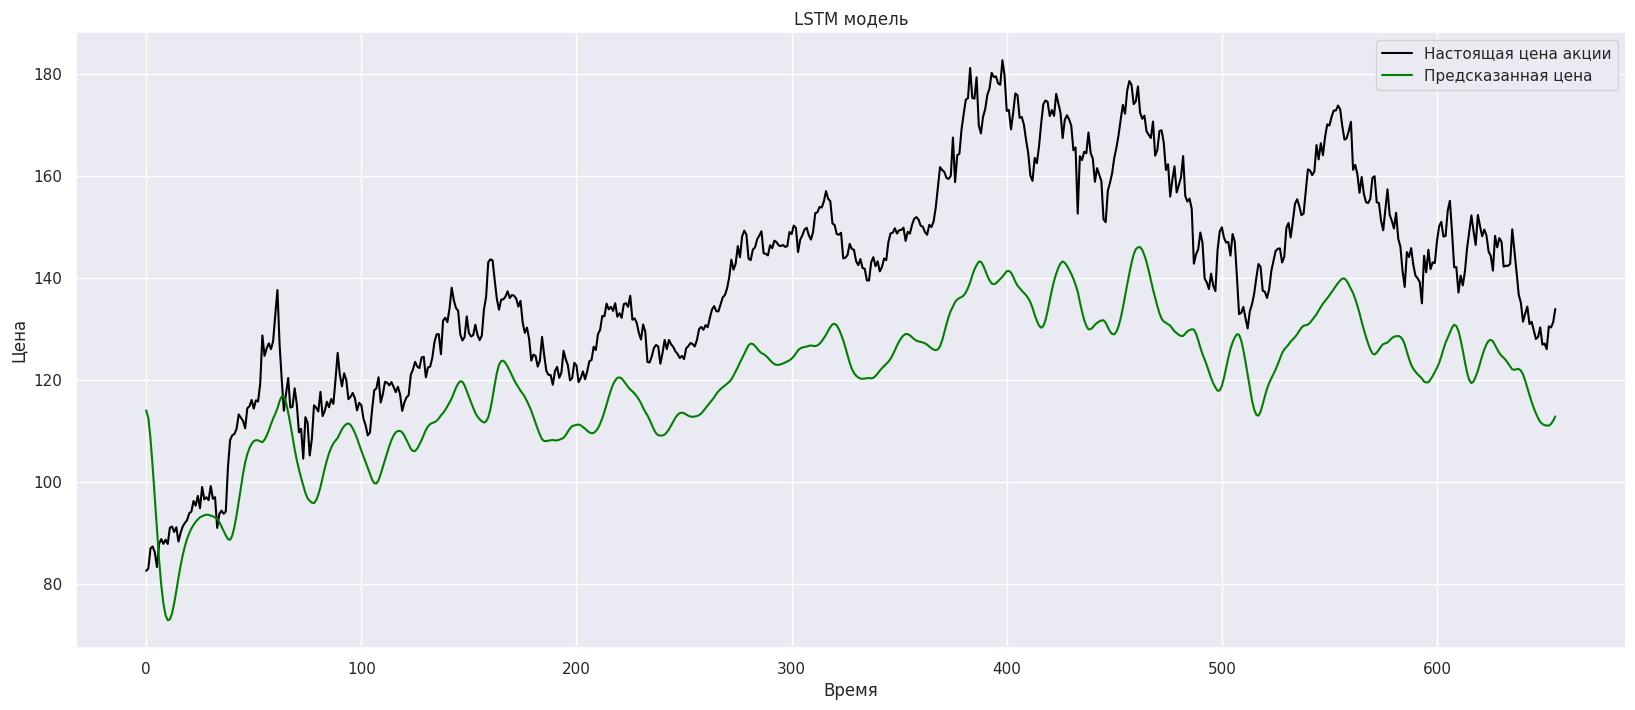

In [ ]:
# создание графика
plt.plot(actual_prices, color='black', label="Настоящая цена акции")
plt.plot(predicted_prices, color='green', label="Предсказанная цена")
plt.title("LSTM модель")
plt.xlabel("Время")
plt.ylabel("Цена")
plt.legend()
plt.show()

In [ ]:
# извлечение последних значений из модели
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# преобразование извлеченных данных в массив
real_data = np.array(real_data)

# создание 3д массива для модели
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# создание прогноза
prediction = model.predict(real_data)

# обратное преобразование
prediction = scaler.inverse_transform(prediction)

# вывод результата пользователю
print(f"Прогноз: {prediction[0][0]}")

1/1 [==============================] - 1s 880ms/step
Прогноз: 100.50150299072266


# **Arima модель**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.7 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [ ]:
# создадим копию датасета и отберем данные
data2 = data.copy()
data2 = data.query("Date >= '2010-01-01'")

In [ ]:
# разделим данные на тестовую и обучающую выборку в соотношении 80/20
training_size = int(len(data)*0.80)
data_len = len(data)
train = data[0:training_size]
test = data[training_size:data_len]

cols = ['Date','Open']
data2 = data2.loc[:,cols]
data2["Date"]=pd.to_datetime(data2["Date"])
data2 = data2.set_index("Date")

In [ ]:
# найдем d
result = adfuller(data2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.095616
p-value: 0.949873


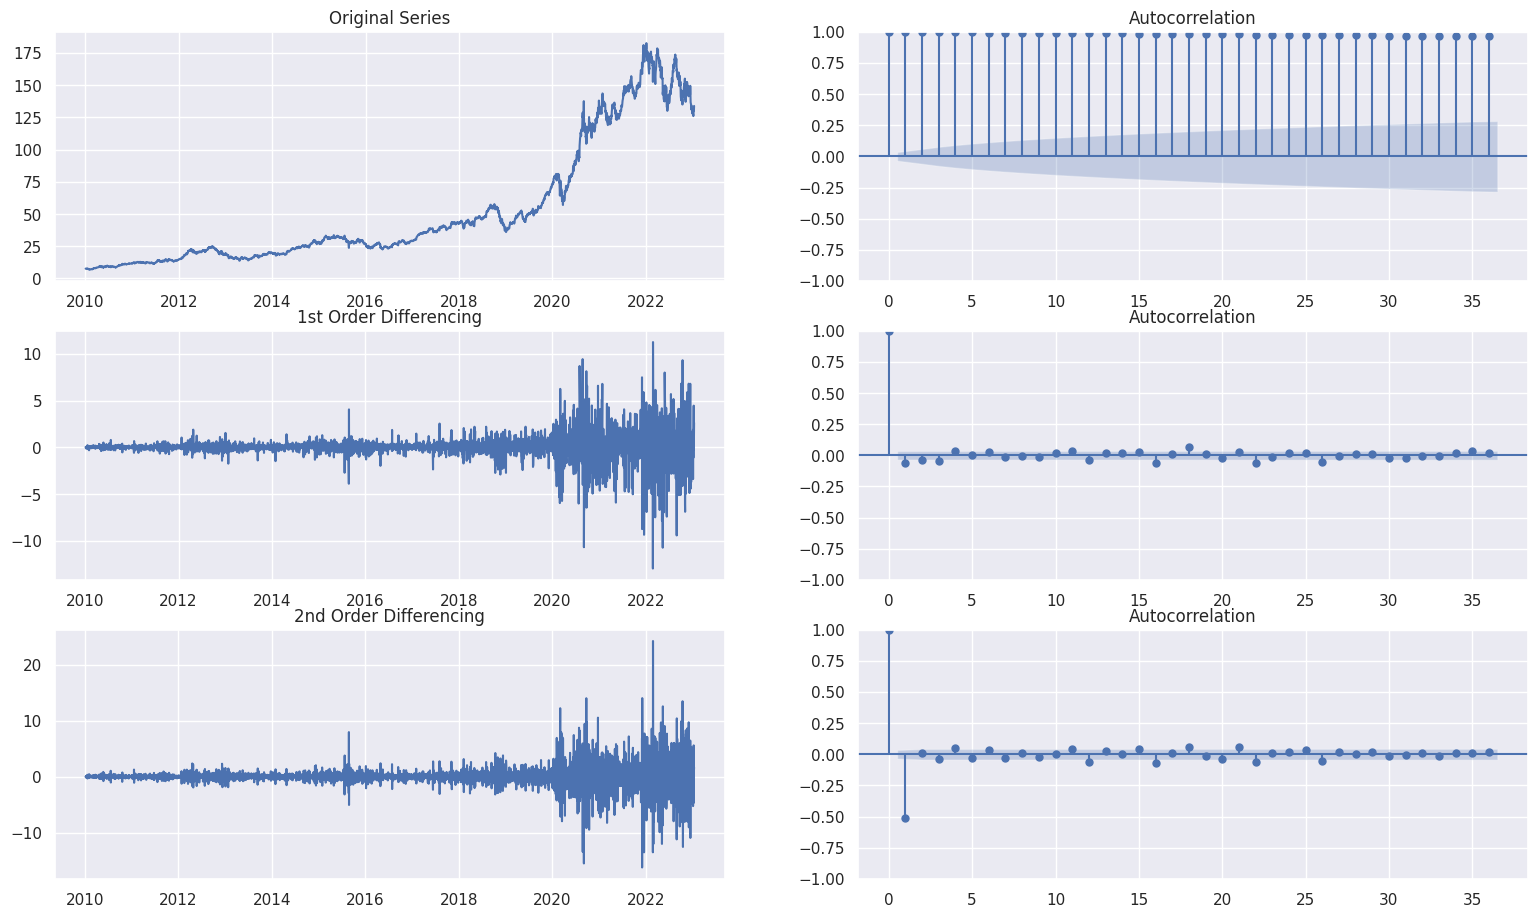

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(19, 11))
axes[0, 0].plot(data2)
axes[0, 0].set_title('Original Series')
plot_acf(data2, ax=axes[0, 1])

axes[1, 0].plot(data2.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data2.diff().dropna(), ax=axes[1, 1])


axes[2, 0].plot(data2.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data2.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
d = 1

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


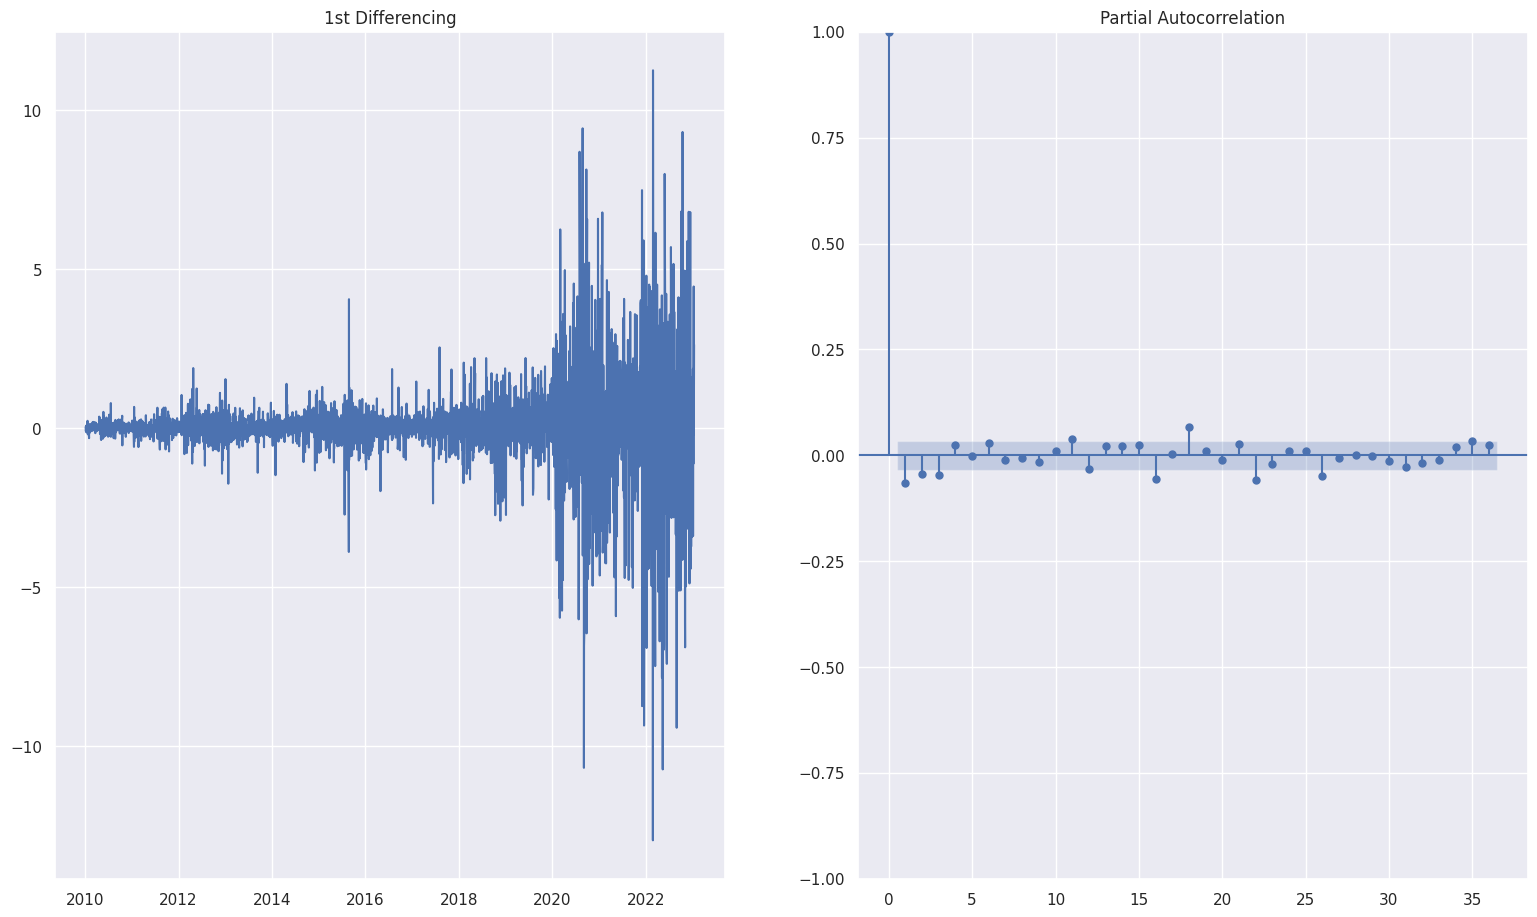

In [ ]:
# найдем p
fig, axes = plt.subplots(1, 2, figsize=(19, 11))
axes[0].plot(data2.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data2.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
p = 1

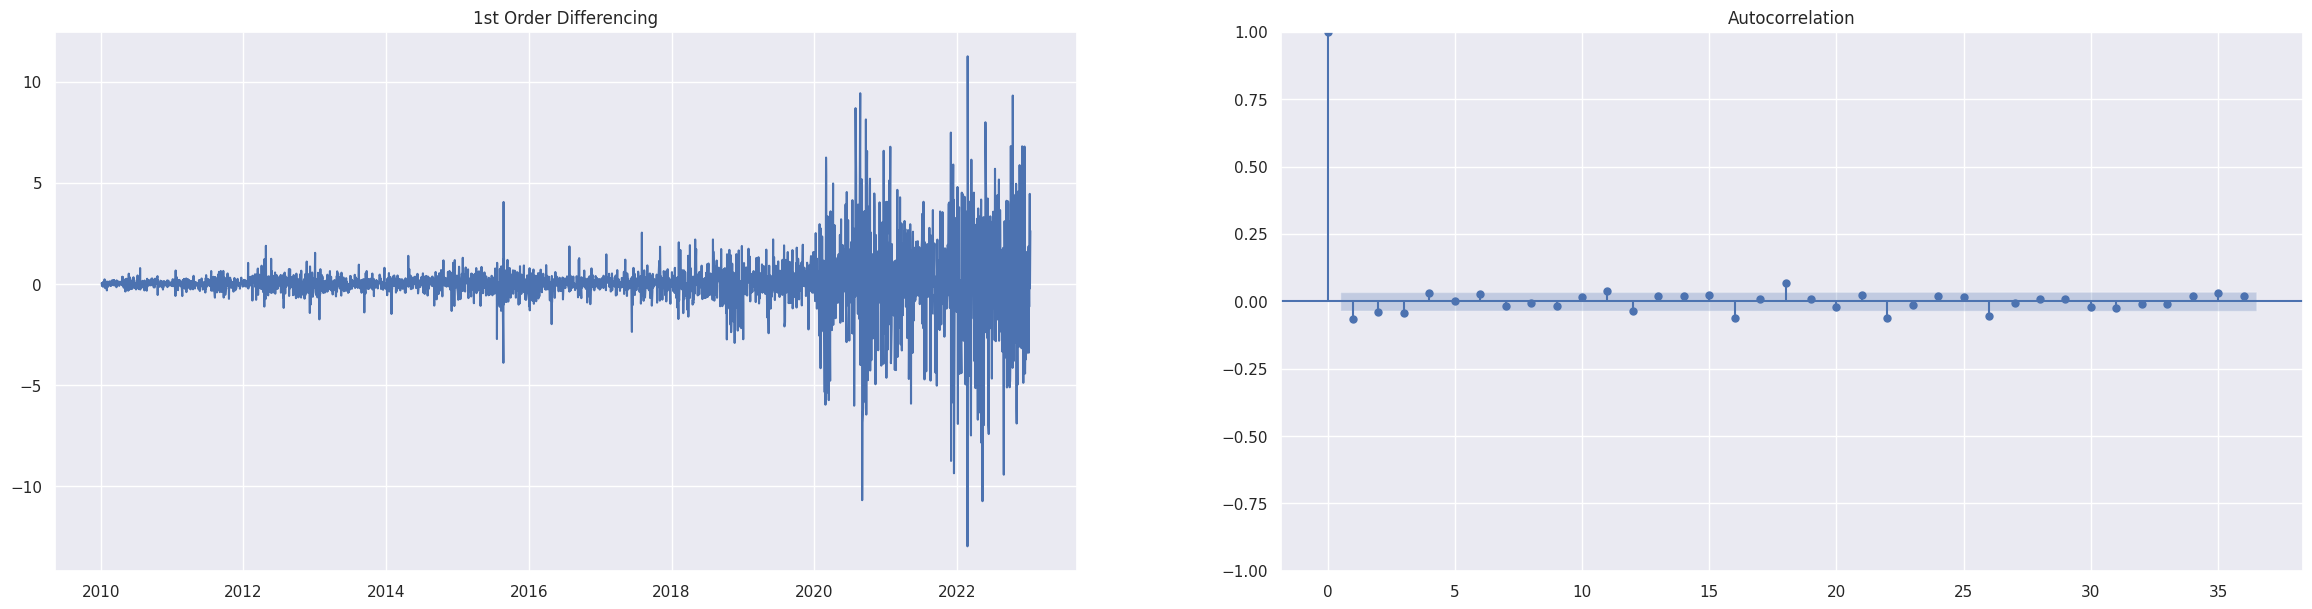

In [ ]:
# найдем q
fig, axes = plt.subplots(1, 2, figsize=(29,7))
# 1st Differencing
axes[0].plot(data2.diff())
axes[0].set_title('1st Order Differencing')
plot_acf(data2.diff().dropna(), ax=axes[1])
plt.show()

In [ ]:
q = 0

In [ ]:
# создание арима модели
model = ARIMA(data2, order=(d,p,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 3280
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5865.086
Date:                Sat, 06 May 2023   AIC                          11734.171
Time:                        09:15:01   BIC                          11746.362
Sample:                             0   HQIC                         11738.536
                               - 3280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.007     -8.830      0.000      -0.078      -0.050
sigma2         2.0948      0.019    110.425      0.000       2.058       2.132
Ljung-Box (L1) (Q):                   0.04   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# расчет прогнозных значений
start_index = 0
end_index = len(data2) - 1
predictions = model_fit.predict(start=start_index, end=end_index)

# расчет RMSE
rmse = np.sqrt(mean_squared_error(data2, predictions))

# вывод результатов
print("RMSE: {:.2f}".format(rmse))

RMSE: 1.45


In [ ]:
def plot_arima(data, model, forecast_size = 10):
  y_pred = model.get_prediction(start = data.index[0]).summary_frame().iloc[1:]
  y_forecast = model.get_forecast(steps=forecast_size).summary_frame()
  y_forecast.index = [data.index[-1] + dt.timedelta(days=i) for i in range(1,forecast_size+1)]
  plt.scatter(data.index, data, color = 'r', label = 'обучающая выборка')
  plt.plot(y_pred.index, y_pred['mean'], label="прогноз обучающей выборки")
  plt.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'], alpha=0.5)
  plt.plot(y_forecast.index, y_forecast['mean'], label="прогноз на будущее")
  plt.fill_between(y_forecast.index, y_forecast['mean_ci_lower'], y_forecast['mean_ci_upper'], alpha=0.5)
  plt.legend()
  plt.xlabel('Дата')
  plt.ylabel('Стоимость')
  plt.title('модель ARIMA')
  plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


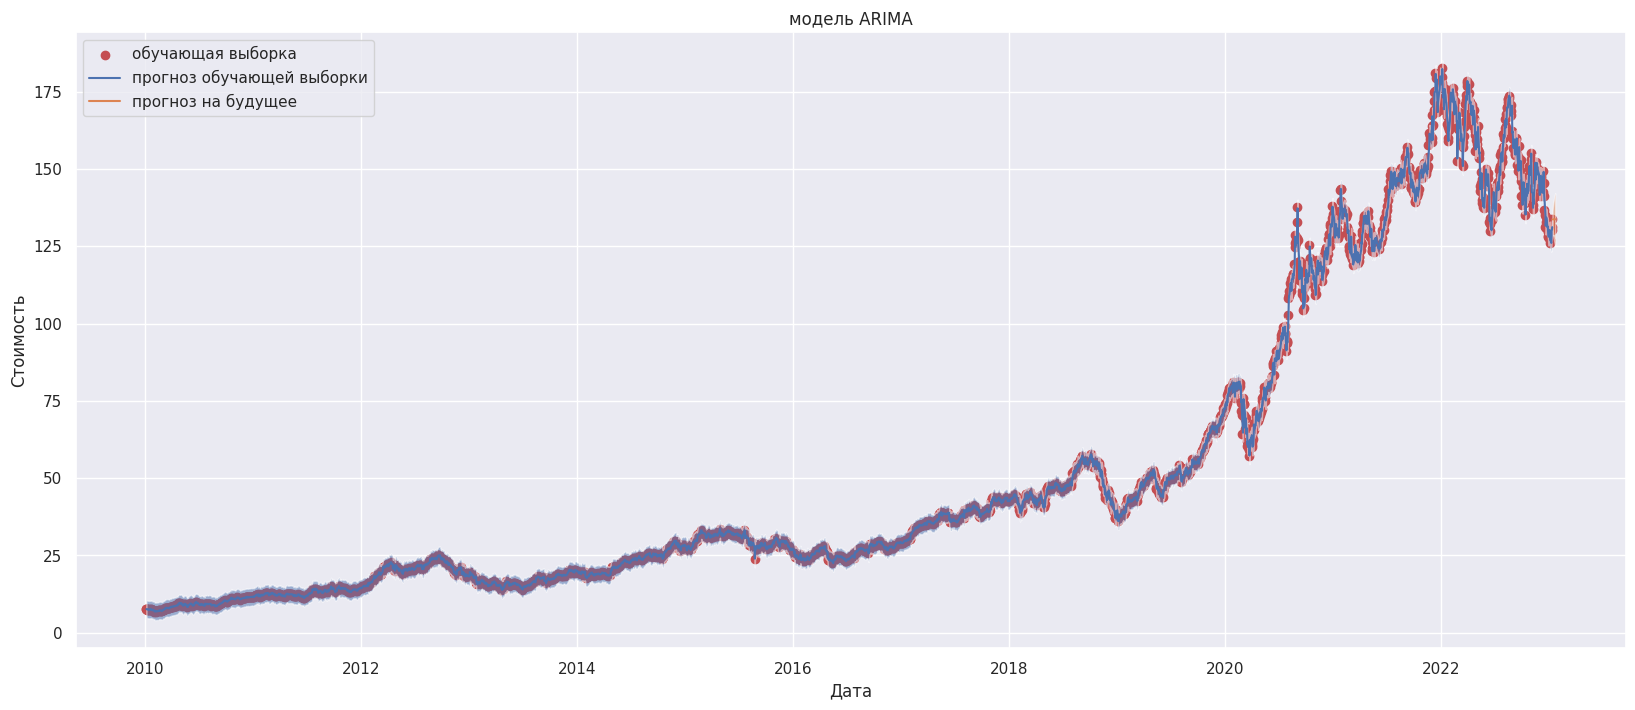

In [ ]:
plot_arima(data2, model_fit, forecast_size = 10)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


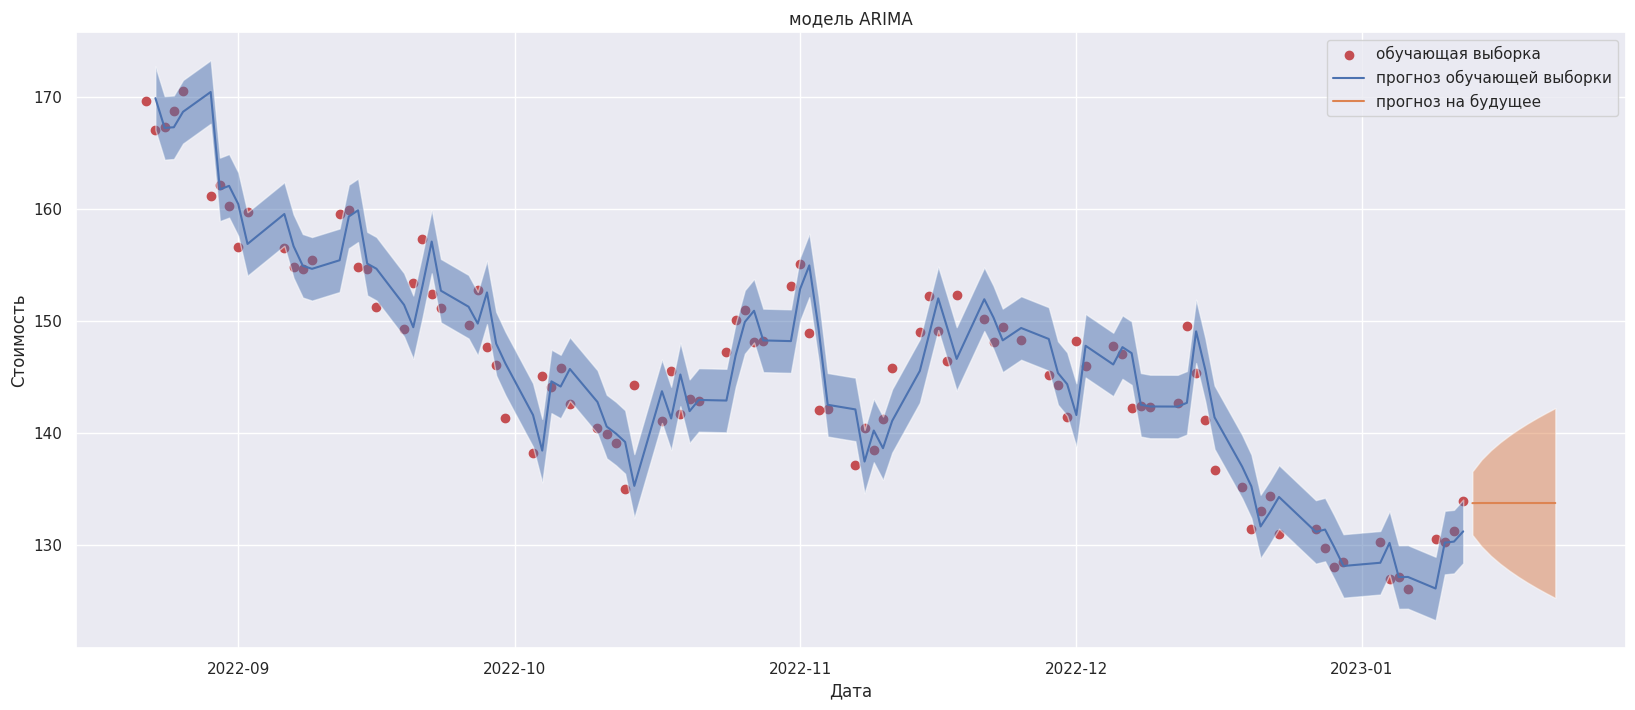

In [ ]:
# Взяли последние 100 наблюдений из обучащей для визуализации
plot_arima(data2.iloc[-100:], model_fit, forecast_size = 10)

# **Prophet модель**

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
# создадим копию датасета и отберем данные
data4 = data.copy()
data4 = data.query("Date >= '2010-01-01'")
# подготовим данные для модели
data4.rename(columns = {'Date':'ds', 'Open':'y'}, inplace = True )
df_new = data4[['ds', 'y']]

In [ ]:
# обучим модель
m = Prophet()
m.fit(df_new)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq7h6b1ww/tep5ade0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq7h6b1ww/ukr5np8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46319', 'data', 'file=/tmp/tmpq7h6b1ww/tep5ade0.json', 'init=/tmp/tmpq7h6b1ww/ukr5np8o.json', 'output', 'file=/tmp/tmpq7h6b1ww/prophet_modelfj0p1noz/prophet_model-20230420114434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# сделаем прогноз на 60 дней
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
3335,2023-03-09
3336,2023-03-10
3337,2023-03-11
3338,2023-03-12
3339,2023-03-13


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3335,2023-03-09,173.524686,163.043098,183.950275
3336,2023-03-10,173.460856,163.828692,184.478734
3337,2023-03-11,174.137352,163.319819,184.823510
3338,2023-03-12,174.167160,164.265887,183.709985
3339,2023-03-13,173.602277,163.404210,184.064409


In [ ]:
plot_plotly(m, forecast)

In [ ]:
m = Prophet()
m.fit(df_new)

future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
fig.update_layout(
    xaxis_title='Временной период',
    yaxis_title='Значения',
    title='Прогноз временного ряда с помощью Prophet'
)
fig.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpevw3fn9u/hcj7wfe3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpevw3fn9u/mofv9y94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99065', 'data', 'file=/tmp/tmpevw3fn9u/hcj7wfe3.json', 'init=/tmp/tmpevw3fn9u/mofv9y94.json', 'output', 'file=/tmp/tmpevw3fn9u/prophet_modelp9g_t14w/prophet_model-20230503095534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:55:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


- Выставлен прогноз на 1 год вперед
- Датасет отобрад с 2010-01-01 и по актульную дату
- Исселодования проводилась в рамках инструкций к логиному

# **LSTM модель 2.0v**

In [ ]:
import matplotlib.pyplot as plt
import pandas_datareader as web

from tensorflow.keras.optimizers import Adamax
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# отбор данных
data = data.query("Date >= '2010-01-01'")
# разделение на выборки
training_size = int(len(data)*0.80)
data_len = len(data)
train = data[0:training_size]
test = data[training_size:data_len]

# нормализация данных
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['Open'].values.reshape(-1,1))

In [ ]:
# переменная прогноза и скольжения
prediction_days = 70

# инициализируйте пустые списки для ввода и вывода обучающих данных
x_train = []
y_train = []

# выполним итерацию по масштабированным данным, начиная с индекса prediction_days
for x in range(prediction_days, len(scaled_data)):
    # добавим значения в созданные списки
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

# преобразуем списки в массив
x_train, y_train = np.array(x_train), np.array(y_train)
# преобразуем в 3д массив как требует того модель
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
def LSTM_model():
    # инициализация модели
    model = Sequential()

    # добавим первый слой LSTM с 100 единицами, входной формой и возвращаемыми последовательностями
    model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # отсев значений чтобы убрать переобучение модели
    model.add(Dropout(0.2))

    # добавим второй слой LSTM с 100 единицами, входной формой и возвращаемыми последовательностями
    model.add(LSTM(units=100, return_sequences=True))
    # отсев значений чтобы убрать переобучение модели
    model.add(Dropout(0.2))

    # добавим третий слой LSTM с 100 единицами
    model.add(LSTM(units=100))
    # отсев значений чтобы убрать переобучение модели
    model.add(Dropout(0.2))

    # выходной слой
    model.add(Dense(units=1))

    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer=Adamax(learning_rate=0.006),
    loss='mean_squared_error'
)

# обучение модели
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size = 32,
    callbacks = [checkpointer]
)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 70, 100)           40800     
                                                                 
 dropout_120 (Dropout)       (None, 70, 100)           0         
                                                                 
 lstm_118 (LSTM)             (None, 70, 100)           80400     
                                                                 
 dropout_121 (Dropout)       (None, 70, 100)           0         
                                                                 
 lstm_119 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_122 (Dropout)       (None, 100)               0         
                                                                 
 dense_38 (Dense)            (None, 1)               

80/80 [==============================] - 6s 12ms/step - loss: 0.0130
Epoch 2/50
76/80 [===========================>..] - ETA: 0s - loss: 0.0012

80/80 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.0011

80/80 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.0010

80/80 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 0.0011

80/80 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 6/50
79/80 [============================>.] - ETA: 0s - loss: 0.0012

80/80 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 7/50
78/80 [============================>.] - ETA: 0s - loss: 8.9812e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.0353e-04
Epoch 8/50
79/80 [============================>.] - ETA: 0s - loss: 0.0012

80/80 [==============================] - 1s 15ms/step - loss: 0.0012
Epoch 9/50
79/80 [============================>.] - ETA: 0s - loss: 9.2578e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.2256e-04
Epoch 10/50
80/80 [==============================] - ETA: 0s - loss: 9.4891e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.4891e-04
Epoch 11/50
76/80 [===========================>..] - ETA: 0s - loss: 8.7977e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.6915e-04
Epoch 12/50
76/80 [===========================>..] - ETA: 0s - loss: 8.8287e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.8068e-04
Epoch 13/50
76/80 [===========================>..] - ETA: 0s - loss: 0.0010    

80/80 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 14/50
76/80 [===========================>..] - ETA: 0s - loss: 8.2215e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.2880e-04
Epoch 15/50
79/80 [============================>.] - ETA: 0s - loss: 8.3692e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.3209e-04
Epoch 16/50
76/80 [===========================>..] - ETA: 0s - loss: 8.2676e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.4573e-04
Epoch 17/50
80/80 [==============================] - ETA: 0s - loss: 9.9850e-04

80/80 [==============================] - 1s 11ms/step - loss: 9.9850e-04
Epoch 18/50
80/80 [==============================] - ETA: 0s - loss: 7.7731e-04

80/80 [==============================] - 1s 11ms/step - loss: 7.7731e-04
Epoch 19/50
80/80 [==============================] - ETA: 0s - loss: 8.9425e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.9425e-04
Epoch 20/50
80/80 [==============================] - ETA: 0s - loss: 7.4640e-04

80/80 [==============================] - 1s 15ms/step - loss: 7.4640e-04
Epoch 21/50
78/80 [============================>.] - ETA: 0s - loss: 6.7207e-04

80/80 [==============================] - 1s 14ms/step - loss: 6.6352e-04
Epoch 22/50
76/80 [===========================>..] - ETA: 0s - loss: 6.8282e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.9647e-04
Epoch 23/50
76/80 [===========================>..] - ETA: 0s - loss: 6.7643e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.9036e-04
Epoch 24/50
80/80 [==============================] - ETA: 0s - loss: 6.2862e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.2862e-04
Epoch 25/50
76/80 [===========================>..] - ETA: 0s - loss: 6.8253e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.7648e-04
Epoch 26/50
80/80 [==============================] - ETA: 0s - loss: 8.2713e-04

80/80 [==============================] - 1s 11ms/step - loss: 8.2713e-04
Epoch 27/50
76/80 [===========================>..] - ETA: 0s - loss: 7.2437e-04

80/80 [==============================] - 1s 11ms/step - loss: 7.0539e-04
Epoch 28/50
80/80 [==============================] - ETA: 0s - loss: 6.6457e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.6457e-04
Epoch 29/50
79/80 [============================>.] - ETA: 0s - loss: 5.7755e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.7642e-04
Epoch 30/50
76/80 [===========================>..] - ETA: 0s - loss: 6.1324e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.0428e-04
Epoch 31/50
80/80 [==============================] - ETA: 0s - loss: 7.4019e-04

80/80 [==============================] - 1s 11ms/step - loss: 7.4019e-04
Epoch 32/50
77/80 [===========================>..] - ETA: 0s - loss: 7.1884e-04

80/80 [==============================] - 1s 13ms/step - loss: 7.2627e-04
Epoch 33/50
77/80 [===========================>..] - ETA: 0s - loss: 7.9550e-04

80/80 [==============================] - 1s 15ms/step - loss: 7.8647e-04
Epoch 34/50
80/80 [==============================] - ETA: 0s - loss: 6.4798e-04

80/80 [==============================] - 1s 12ms/step - loss: 6.4798e-04
Epoch 35/50
79/80 [============================>.] - ETA: 0s - loss: 5.7230e-04

80/80 [==============================] - 1s 12ms/step - loss: 5.9518e-04
Epoch 36/50
79/80 [============================>.] - ETA: 0s - loss: 5.3729e-04

80/80 [==============================] - 1s 12ms/step - loss: 5.3455e-04
Epoch 37/50
79/80 [============================>.] - ETA: 0s - loss: 5.6988e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.6939e-04
Epoch 38/50
79/80 [============================>.] - ETA: 0s - loss: 5.9747e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.0697e-04
Epoch 39/50
76/80 [===========================>..] - ETA: 0s - loss: 7.0838e-04

80/80 [==============================] - 1s 11ms/step - loss: 7.0725e-04
Epoch 40/50
76/80 [===========================>..] - ETA: 0s - loss: 4.9423e-04

80/80 [==============================] - 1s 11ms/step - loss: 4.9155e-04
Epoch 41/50
80/80 [==============================] - ETA: 0s - loss: 6.2276e-04

80/80 [==============================] - 1s 11ms/step - loss: 6.2276e-04
Epoch 42/50
78/80 [============================>.] - ETA: 0s - loss: 5.4268e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.4503e-04
Epoch 43/50
79/80 [============================>.] - ETA: 0s - loss: 5.3817e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.4199e-04
Epoch 44/50
80/80 [==============================] - ETA: 0s - loss: 5.3675e-04

80/80 [==============================] - 1s 12ms/step - loss: 5.3675e-04
Epoch 45/50
80/80 [==============================] - ETA: 0s - loss: 6.8785e-04

80/80 [==============================] - 1s 15ms/step - loss: 6.8785e-04
Epoch 46/50
77/80 [===========================>..] - ETA: 0s - loss: 5.3034e-04

80/80 [==============================] - 1s 12ms/step - loss: 5.2723e-04
Epoch 47/50
78/80 [============================>.] - ETA: 0s - loss: 5.4904e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.4825e-04
Epoch 48/50
76/80 [===========================>..] - ETA: 0s - loss: 5.5571e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.5465e-04
Epoch 49/50
80/80 [==============================] - ETA: 0s - loss: 5.1116e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.1116e-04
Epoch 50/50
80/80 [==============================] - ETA: 0s - loss: 5.1662e-04

80/80 [==============================] - 1s 11ms/step - loss: 5.1662e-04


In [ ]:
test = data[training_size:data_len]
test_data = test
# извлечение фактических цен открытия из тестовых данных
actual_prices = test_data['Open'].values

# обьединение данных
total_dataset = pd.concat((data['Open'], test_data['Open']), axis=0)

# извлечение части данных
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# преобразование данных в массив с одни столбцом
model_inputs = model_inputs.reshape(-1, 1)

# соотнесение данных обучающие и тестовые
model_inputs = scaler.transform(model_inputs)

In [ ]:
# создание пустого списка
x_test = []

# инициализируйте пустые списки для ввода и вывода обучающих данных
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# конвертация типов данных
x_test = np.array(x_test)

# подготовка данных
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# создание прогноза
predicted_prices = model.predict(x_test)

# конвертирование прогноза
predicted_prices = scaler.inverse_transform(predicted_prices)

21/21 [==============================] - 1s 7ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predicted_prices - actual_prices) ** 2)))
print("RMSE:", rmse)

RMSE: 26.434674094127104


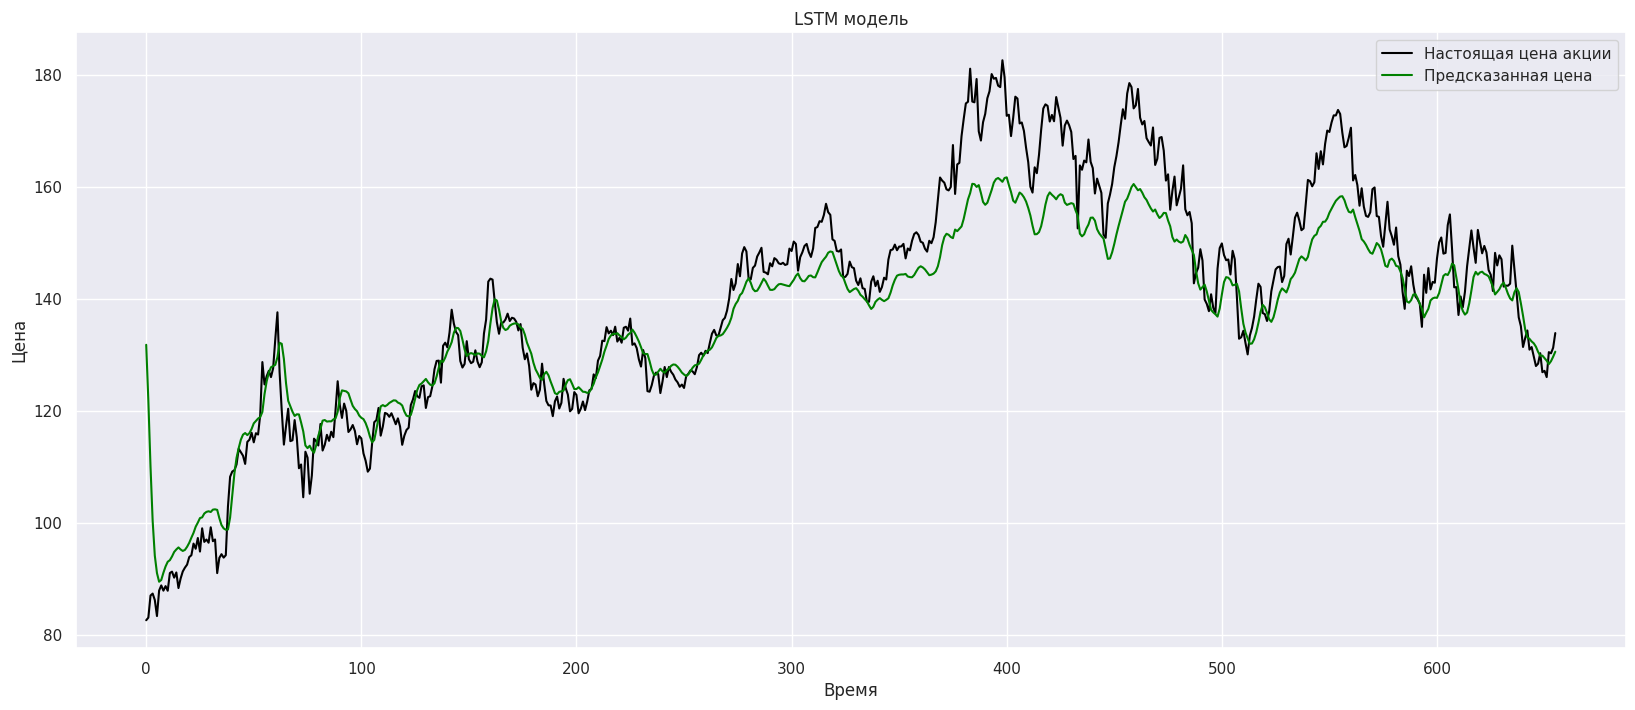

In [ ]:
# создание графика
plt.plot(actual_prices, color='black', label="Настоящая цена акции")
plt.plot(predicted_prices, color='green', label="Предсказанная цена")
plt.title("LSTM модель")
plt.xlabel("Время")
plt.ylabel("Цена")
plt.legend()
plt.show()

In [ ]:
def plot_lstm(X, model, training_size , forecast_size =10, prediction_days = 70 ):
  date = list(X.Date)
  X = X.Open.values
  y_pred_train = []
  X_train = []
  X_test = []
  for  i in range(prediction_days, training_size):
    X_train.append(scaler.transform(X[i-prediction_days:i].reshape(-1,1)))
  X_train = np.array(X_train)
  y_pred_train = scaler.inverse_transform(model.predict(X_train, verbose=0))
  y_true_train = X[prediction_days:training_size]
  for  i in range(training_size, len(X)):
    X_test.append(scaler.transform(X[i-prediction_days:i].reshape(-1,1)))
  X_test = np.array(X_test)
  y_pred_test = scaler.inverse_transform(model.predict(X_test, verbose=0))
  y_true_test = X[training_size: len(X)]

  start = scaler.transform(X[-prediction_days:].reshape(-1,1))
  forecast_list = []
  for i in range(forecast_size):
    date.append(date[-1] + dt.timedelta(days = 1))
    forecast = model.predict(start.reshape(1,-1,1), verbose=0)
    forecast_list.append(scaler.inverse_transform(forecast)[0])
    start = np.append(start, forecast[0])
    start = start[-prediction_days:]

  plt.scatter(x= date[prediction_days: training_size], y = y_true_train, label = 'обучающая выборка',  color = 'r')
  plt.plot(date[prediction_days: training_size], y_pred_train, label = 'прогноз обучающей выборки', color = 'b')
  plt.scatter(x= date[training_size: len(X)], y = y_true_test, label = 'тестовая выборка', color = 'y')
  plt.plot(date[training_size: len(X)], y_pred_test, label = 'прогноз тестовой выборки', color = 'g')
  plt.plot(date[len(X): len(X)+forecast_size], forecast_list, label = 'прогноз на будущее', color = 'r')
  plt.legend()
  plt.xlabel('Дата')
  plt.ylabel('Стоимость')
  plt.title('модель LSTM')
  plt.show()
  return None

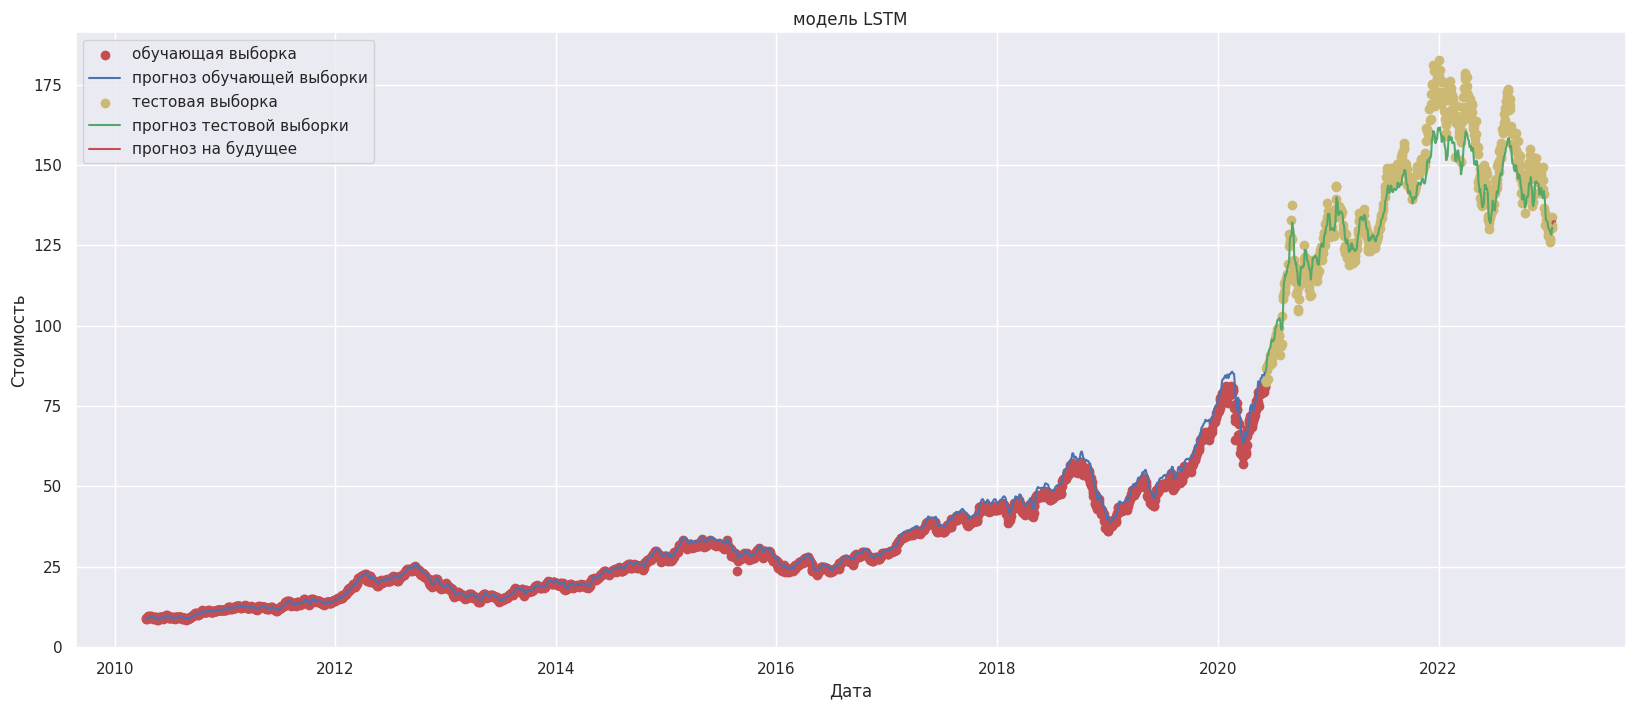

In [ ]:
plot_lstm(data, model, training_size, forecast_size = 10)

In [ ]:
def plot_lstm_small(X, model, training_size, forecast_size=10, prediction_days=70):
    date = list(X.Date)
    X = X.Open.values

    y_pred_train = []
    X_train = []
    X_test = []

    for i in range(prediction_days, training_size):
        X_train.append(scaler.transform(X[i-prediction_days:i].reshape(-1,1)))
    X_train = np.array(X_train)
    y_pred_train = scaler.inverse_transform(model.predict(X_train, verbose=0))
    y_true_train = X[prediction_days:training_size]

    for i in range(training_size, len(X)):
        X_test.append(scaler.transform(X[i-prediction_days:i].reshape(-1,1)))
    X_test = np.array(X_test)
    y_pred_test = scaler.inverse_transform(model.predict(X_test, verbose=0))
    y_true_test = X[training_size: len(X)]

    start = scaler.transform(X[-prediction_days:].reshape(-1,1))
    forecast_list = []

    for i in range(forecast_size):
        date.append(date[-1] + dt.timedelta(days=1))
        forecast = model.predict(start.reshape(1,-1,1), verbose=0)
        forecast_list.append(scaler.inverse_transform(forecast)[0])
        start = np.append(start, forecast[0])
        start = start[-prediction_days:]

    plot_date_range = date[-350:]

    plt.scatter(x=date[prediction_days:training_size], y=y_true_train, label='обучающая выборка',  color='r')
    plt.plot(date[prediction_days:training_size], y_pred_train, label='прогноз обучающей выборки', color='b')
    plt.scatter(x=date[training_size:len(X)], y=y_true_test, label='тестовая выборка', color='y')
    plt.plot(date[training_size:len(X)], y_pred_test, label='прогноз тестовой выборки', color='g')
    plt.plot(date[len(X):len(X)+forecast_size], forecast_list, label='прогноз на будущее', color='r')
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel('Стоимость')
    plt.title('модель LSTM')
    plt.xlim([plot_date_range[0], plot_date_range[-1]])
    plt.show()

    return None


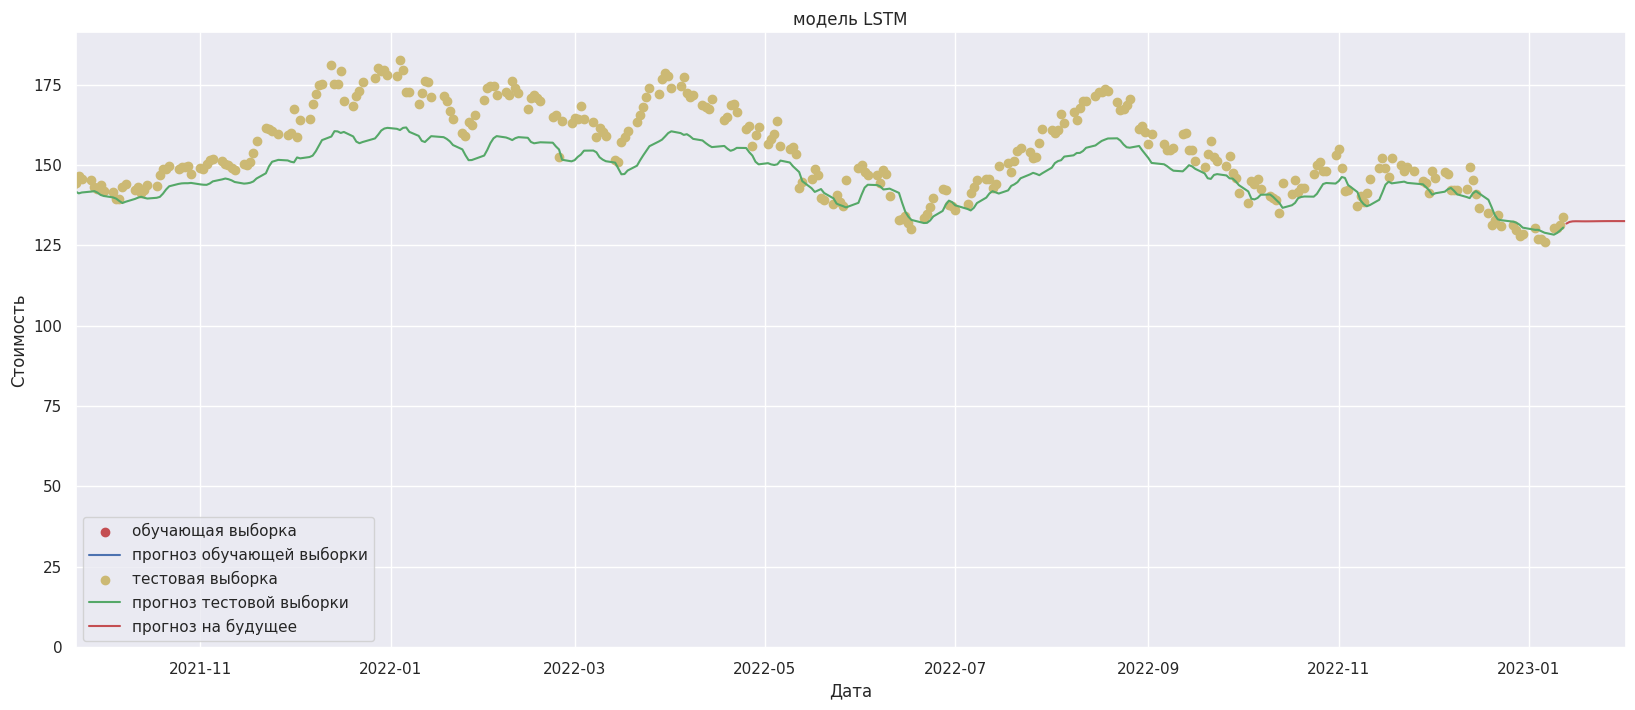

In [ ]:
plot_lstm_small(data, model, training_size, forecast_size = 20)